# Instructions

Before running, upload the dataset to your google drive in a folder called "UCI HAR Dataset". The folder should be located in "MyDrive" and have the structure:

UCI HAR Dataset
- train/
- test/
- features.txt
- activity_labels.txt

The dataset can be downloaded from:
https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones

Also, change runtime type to GPU for the deep learning models.

# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Input

drive.mount('/drive')

Mounted at /drive


# Preprocessing

In [ ]:
# Load feature names
features = pd.read_csv('/drive/MyDrive/UCI HAR Dataset/features.txt', sep='\s+', header=None)
feature_names = features[1].values

# Load activity labels
activity_labels = pd.read_csv('/drive/MyDrive/UCI HAR Dataset/activity_labels.txt', sep='\s+', header=None, index_col=0)

# Load train data
X_train = pd.read_csv('/drive/MyDrive/UCI HAR Dataset/train/X_train.txt', sep='\s+', header=None)
y_train = pd.read_csv('/drive/MyDrive/UCI HAR Dataset/train/y_train.txt', header=None)

# Load test data
X_test = pd.read_csv('/drive/MyDrive/UCI HAR Dataset/test/X_test.txt', sep='\s+', header=None)
y_test = pd.read_csv('/drive/MyDrive/UCI HAR Dataset/test/y_test.txt', header=None)

# Set column names
X_train.columns = feature_names
X_test.columns = feature_names

# Combine datasets
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])
y = y[0].map(activity_labels[1])

print(X.shape)
print(y.shape)
print(y.head())

(10299, 561)
(10299,)
0    STANDING
1    STANDING
2    STANDING
3    STANDING
4    STANDING
Name: 0, dtype: object


## Preprocessing for Deep Learning

In [ ]:
def load_signals(signal_type, dataset="train"):
    path = f"/drive/MyDrive/UCI HAR Dataset/{dataset}/Inertial Signals/{signal_type}_{dataset}.txt"
    return np.loadtxt(path)

# List of signals
signals = [
    "body_acc_x", "body_acc_y", "body_acc_z",
    "body_gyro_x", "body_gyro_y", "body_gyro_z",
    "total_acc_x", "total_acc_y", "total_acc_z"
]

# Load train data
X_train_raw = np.array([load_signals(sig, "train") for sig in signals])
X_train_raw = np.transpose(X_train_raw, (1, 2, 0))  # shape: (samples, timesteps, channels)

# Load test data
X_test_raw = np.array([load_signals(sig, "test") for sig in signals])
X_test_raw = np.transpose(X_test_raw, (1, 2, 0))

# Load labels
y_train_raw = y_train.values.ravel()
y_test_raw = y_test.values.ravel()

# Encoding
encoder = LabelEncoder()
y_train_enc = to_categorical(encoder.fit_transform(y_train_raw))
y_test_enc = to_categorical(encoder.transform(y_test_raw))

print(X_train_raw.shape)
print(X_test_raw.shape)
print(y_train_enc.shape)
print(y_test_enc.shape)

(7352, 128, 9)
(2947, 128, 9)
(7352, 6)
(2947, 6)


# Machine Learning Models

In [ ]:
# === 1. Encode Labels and Scale Features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# === 2. Split Data (80% train, 20% test) ===
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

## KNN Classifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_split, y_train_split)
y_pred_knn = knn.predict(X_val)
accuracy_val_knn = accuracy_score(y_val, y_pred_knn)

print(classification_report(y_val, y_pred_knn, target_names=encoder.classes_))

                    precision    recall  f1-score   support

            LAYING       1.00      0.99      1.00       389
           SITTING       0.96      0.88      0.92       356
          STANDING       0.90      0.97      0.93       381
           WALKING       0.98      1.00      0.99       344
WALKING_DOWNSTAIRS       0.99      0.98      0.99       281
  WALKING_UPSTAIRS       0.99      0.99      0.99       309

          accuracy                           0.97      2060
         macro avg       0.97      0.97      0.97      2060
      weighted avg       0.97      0.97      0.97      2060



## Random Forest Classifier

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_split, y_train_split)
y_pred_rf = rf.predict(X_val)
accuracy_val_rf = accuracy_score(y_val, y_pred_rf)

print(classification_report(y_val, y_pred_rf, target_names=encoder.classes_))

                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       389
           SITTING       0.97      0.97      0.97       356
          STANDING       0.98      0.97      0.97       381
           WALKING       0.99      0.98      0.99       344
WALKING_DOWNSTAIRS       0.98      0.97      0.97       281
  WALKING_UPSTAIRS       0.96      0.99      0.97       309

          accuracy                           0.98      2060
         macro avg       0.98      0.98      0.98      2060
      weighted avg       0.98      0.98      0.98      2060



## Confusion Matrix

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=encoder.classes_,
                yticklabels=encoder.classes_,
                cmap='Blues')
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

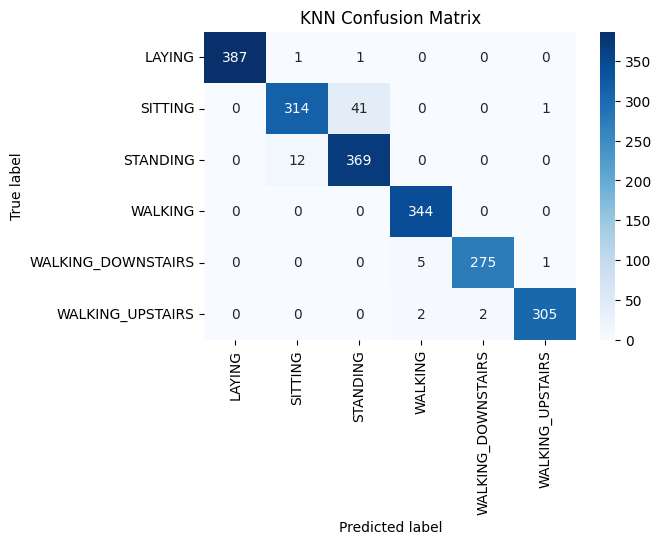

In [ ]:
plot_confusion_matrix(y_val, y_pred_knn, "KNN Confusion Matrix")

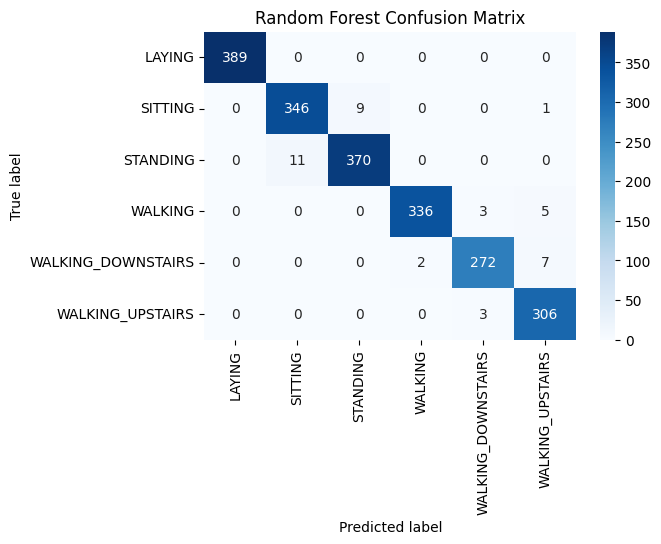

In [ ]:
plot_confusion_matrix(y_val, y_pred_rf, "Random Forest Confusion Matrix")

# Deep Learning Models

## CNN

In [ ]:
cnn = Sequential([
    Input(shape=(128, 9)),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2),
    Dropout(0.3),

    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(y_train_enc.shape[1], activation='softmax')
])

cnn.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

cnn_history = cnn.fit(X_train_raw, y_train_enc,
        epochs=20,
        batch_size=64,
        validation_split=0.2,
        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.5836 - loss: 0.9797 - val_accuracy: 0.8586 - val_loss: 0.4785
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8839 - loss: 0.3124 - val_accuracy: 0.8994 - val_loss: 0.3632
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9360 - loss: 0.1657 - val_accuracy: 0.8994 - val_loss: 0.3894
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9512 - loss: 0.1280 - val_accuracy: 0.9103 - val_loss: 0.4245
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9559 - loss: 0.1054 - val_accuracy: 0.9143 - val_loss: 0.4234


## LSTM

In [ ]:
lstm = Sequential([
    Input(shape=(128, 9)),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(y_train_enc.shape[1], activation='softmax')
])

lstm.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

lstm_history = lstm.fit(X_train_raw, y_train_enc,
         epochs=20,
         batch_size=64,
         validation_split=0.2,
         callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.3999 - loss: 1.4138 - val_accuracy: 0.6363 - val_loss: 0.9041
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6773 - loss: 0.7377 - val_accuracy: 0.6506 - val_loss: 0.9554
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7432 - loss: 0.6436 - val_accuracy: 0.7464 - val_loss: 0.7458
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8119 - loss: 0.4668 - val_accuracy: 0.7417 - val_loss: 0.7259
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8452 - loss: 0.4133 - val_accuracy: 0.8715 - val_loss: 0.4937
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7930 - loss: 0.6458 - val_accuracy: 0.8702 - val_loss: 0.4614
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9321 - loss: 0.2225 - val_accuracy: 0.8797 - val_loss: 0.4198
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9419 - loss: 0.1817 - val_accuracy: 0.8933 - v

## CNN-LSTM

In [ ]:
cnn_lstm = Sequential([
    Input(shape=(128, 9, 1)),
    TimeDistributed(Conv1D(64, 3, activation='relu')),
    TimeDistributed(MaxPooling1D(2)),
    TimeDistributed(Dropout(0.3)),
    TimeDistributed(Flatten()),

    LSTM(64),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(y_train_enc.shape[1], activation='softmax')
])

# Reshape to (samples, timesteps, channels, 1) for TimeDistributed
X_train_reshaped = X_train_raw.reshape((X_train_raw.shape[0], X_train_raw.shape[1], X_train_raw.shape[2], 1))

cnn_lstm.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

cnnlstm_history = cnn_lstm.fit(X_train_reshaped, y_train_enc,
             epochs=20,
             batch_size=64,
             validation_split=0.2,
             callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 46s 157ms/step - accuracy: 0.3476 - loss: 1.4622 - val_accuracy: 0.5404 - val_loss: 1.0607
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - accuracy: 0.5316 - loss: 0.9383 - val_accuracy: 0.2026 - val_loss: 2.4414
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.4037 - loss: 1.4431 - val_accuracy: 0.5663 - val_loss: 0.7639
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accuracy: 0.6299 - loss: 0.7615 - val_accuracy: 0.6281 - val_loss: 0.7039
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.6420 - loss: 0.8005 - val_accuracy: 0.8008 - val_loss: 0.5604
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step - accuracy: 0.7268 - loss: 0.6059 - val_accuracy: 0.7362 - val_loss: 0.6074
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - accuracy: 0.7769 - loss: 0.5437 - val_accuracy: 0.8600 - val_loss: 0.3992
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.8302 - loss: 0.4451 - val_accuracy: 0.8

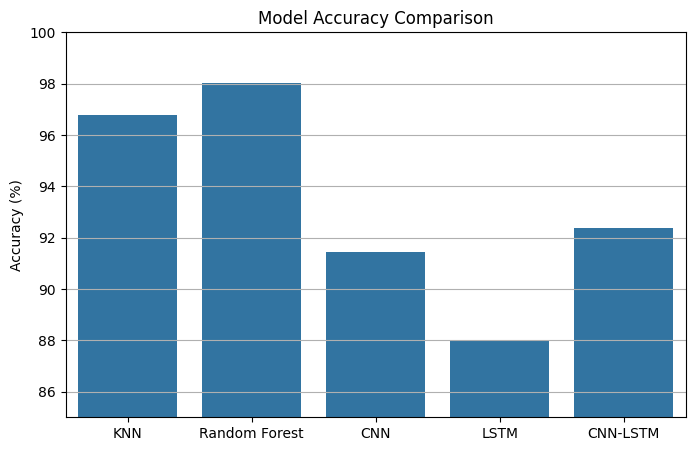

In [ ]:
import seaborn as sns
from sklearn.metrics import accuracy_score


def plot_model_accuracies(model_names, accuracies):
    plt.figure(figsize=(8, 5))
    sns.barplot(x=model_names, y=accuracies, legend='auto')
    plt.ylim(85, 100)
    plt.ylabel('Accuracy (%)')
    plt.title('Model Accuracy Comparison')
    plt.grid(axis='y')
    plt.show()

# Compute accuracies
acc_knn = accuracy_val_knn * 100
acc_rf = accuracy_val_rf * 100
acc_cnn = cnn_history.history['val_accuracy'][-1] * 100
acc_lstm = lstm_history.history['val_accuracy'][-1] * 100
acc_cnnlstm = cnnlstm_history.history['val_accuracy'][-1] * 100

model_names = ['KNN', 'Random Forest', 'CNN', 'LSTM', 'CNN-LSTM']
accuracies = [acc_knn, acc_rf, acc_cnn, acc_lstm, acc_cnnlstm]

# Plot
plot_model_accuracies(model_names, accuracies)